# Lab 13: Autoencoders and Variational Autoencoders


In [2]:
#!pip install imgaug

In [3]:
## load the libraries
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.metrics import *
from keras.optimizers import Adam, RMSprop
from scipy.stats import norm
from keras.preprocessing import image

from keras import backend as K

from imgaug import augmenters
import matplotlib.pyplot as plt
plt.gray()

<Figure size 640x480 with 0 Axes>

## Part 1: Data

### Reading data

Download the data given at the following link:

https://drive.google.com/file/d/1LWAVDoDCpfgnRcCStxZv9q0oyJnkjdhf/view?usp=sharing

Use pandas and numpy to read in the data as a matrix

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip '/content/Lab 13-fashion_mnist_.zip'

Archive:  /content/Lab 13-fashion_mnist_.zip
  inflating: fashion-mnist_test.csv  
   creating: __MACOSX/
  inflating: __MACOSX/._fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: __MACOSX/._fashion-mnist_train.csv  


In [8]:
### read dataset

train = pd.read_csv("/content/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values

### create train and validation datasets with a test size of 0.15

train_x, val_x = train_test_split(train_x, test_size=0.15)

In [9]:
## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [10]:
train_x.shape

(51000, 28, 28, 1)

### Visualizing Samples

**Visualize 10 images from dataset. Done**

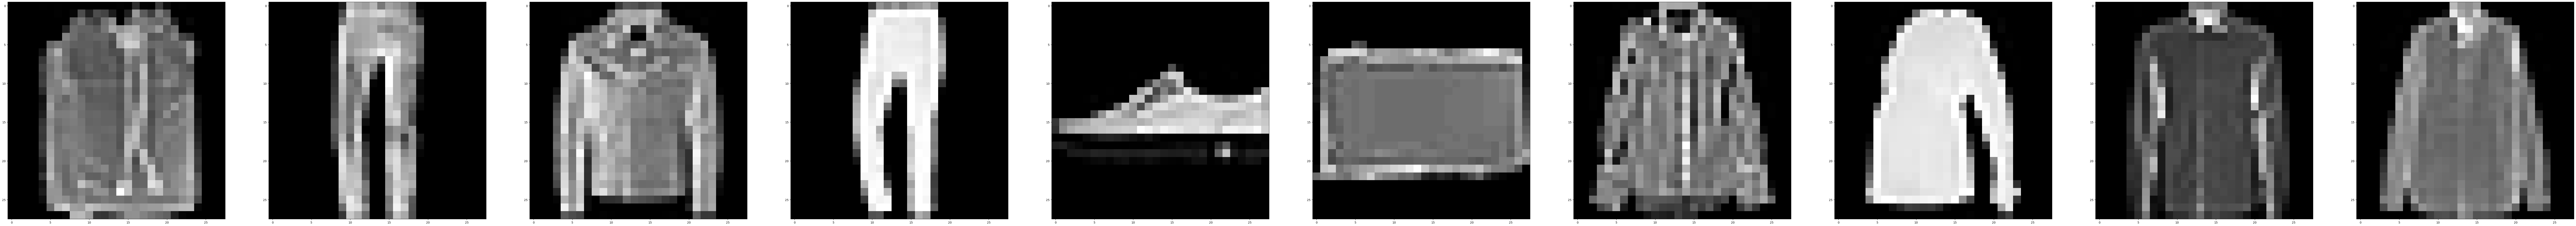

In [26]:
f, ax = plt.subplots(1, 10)
f.set_size_inches(160, 40)
for i in range(10, 20):
    ax[i-10].imshow(train_x[i, :, :, 0].reshape(28, 28))

## Part 2: Denoise Images using AEs

### Understanding AEs

Reference Article: https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

![Autoencoders](https://cdn-images-1.medium.com/max/1600/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png)

#### **Question-1: What are autoencoders, and why are they considered unsupervised learning models?**

Autoencoders are neural networks designed to reconstruct their input. They consist of an encoder that compresses the input into a latent representation and a decoder that reconstructs the input from this representation.

They are considered unsupervised because they do not require labeled data; the goal is to minimize the difference between the input and its reconstruction.

#### **Question-2: How does the structure of an autoencoder ensure that it learns a compressed representation of the input data?**


The structure of an autoencoder maps the input to a smaller latent space, effectively forcing the network to learn a compressed representation. This bottleneck forces the network to prioritize the most essential features for reconstruction, discarding noise and redundant information.

#### **Question-3: What are the key components of an autoencoder, and what are their roles?**

**Encoder:** Maps the input data to a latent space representation.

**Latent Space:** Stores the compressed representation of the input.

**Decoder:** Reconstructs the original input from the latent representation.

**Loss Function:** Measures the difference between the input and its reconstruction, guiding the optimization process.

### Add Noise to Images

Check out [imgaug docs](https://imgaug.readthedocs.io/en/latest/source/api_augmenters_arithmetic.html) for more info and other ways to add noise.

In [21]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255

**Modified the code to view 10 noise added images instead of previously given 5.**

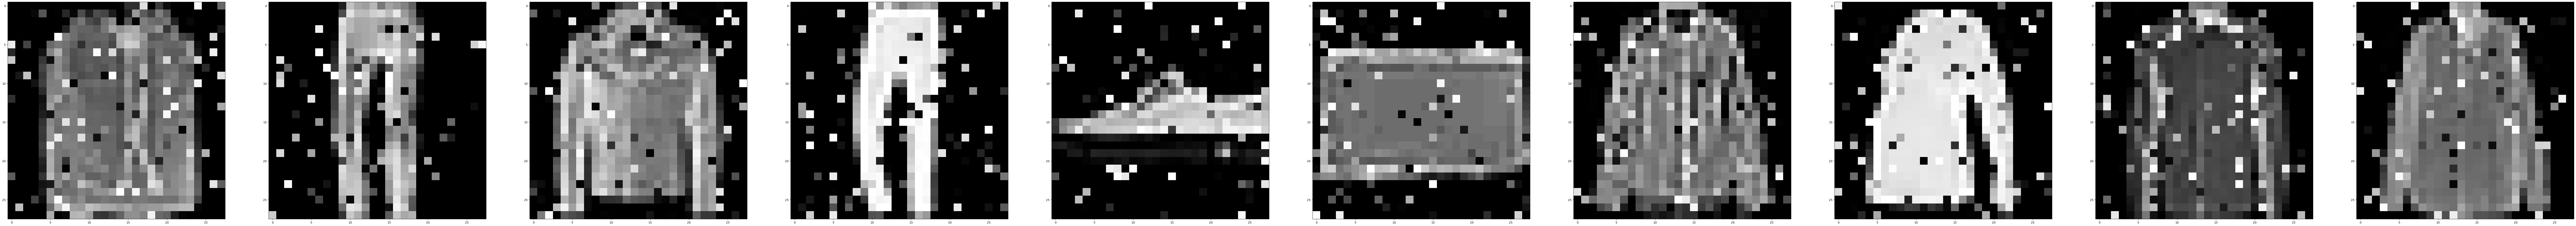

In [27]:
f, ax = plt.subplots(1, 10)
f.set_size_inches(160, 40)
for i in range(10, 20):
    ax[i-10].imshow(train_x_n[i, :, :, 0].reshape(28, 28))

### Setup Encoder Neural Network

TASK: Try different number of hidden layers, nodes, etc.

In [32]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(128, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

### Setup Decoder Neural Network

TASK: Try different number of hidden layers, nodes, etc.

**Increased the layer sizes for better results**

In [33]:
# decoding architecture
decoded_layer1 = Conv2D(32, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(128, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

### Train AE

In [34]:
# compile the model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')

In [35]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 7, 7, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 1)           │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 196,289 (766.75 KB)

 Trainable params: 196,289 (766.75 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model.fit(train_x_n, train_x, epochs=20, batch_size=2048, validation_data=(val_x_n, val_x), callbacks=[early_stopping])

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 0.1327 - val_loss: 0.0524
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/step - loss: 0.0469 - val_loss: 0.0356
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - loss: 0.0335 - val_loss: 0.0287
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - loss: 0.0276 - val_loss: 0.0252
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - loss: 0.0243 - val_loss: 0.0228
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - loss: 0.0222 - val_loss: 0.0213
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - loss: 0.0212 - val_loss: 0.0204
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - loss: 0.0198 - val_loss: 0.0195
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - loss: 0.0192 - val_loss: 0.0190
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - loss: 0.0186 - val_loss: 0.0182
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - loss: 0.0180 - val_loss: 0.0179
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step 

#### **Question-4: What does the loss function represent in the context of an autoencoder?**


The loss function, often mean squared error (MSE), quantifies the difference between the input and its reconstructed output. It ensures that the network learns to faithfully reconstruct the input data.

#### **Question-5: How does the choice of activation functions (e.g., ReLU, Sigmoid) impact the performance of an autoencoder?**


Activation functions control the transformations in each layer:

**ReLU:** Helps in training deeper networks by mitigating vanishing gradient issues.

**Sigmoid:** Compresses outputs to the range [0, 1], making it suitable for inputs normalized within this range.

The choice depends on the data and desired representation.

#### **Question-6: What are the implications of increasing or decreasing the size of the latent space in an autoencoder?**

**Increasing:** Captures more detailed features but risks overfitting.

**Decreasing:** Forces the model to learn only the most critical features, but overly small latent spaces may lose important information.

### Visualize Intermediate Layers of AE

Visualize intermediate layers

In [37]:
# compile the model
model_2 = Model(input_layer, latent_view)
model_2.compile(optimizer='adam', loss='mse')

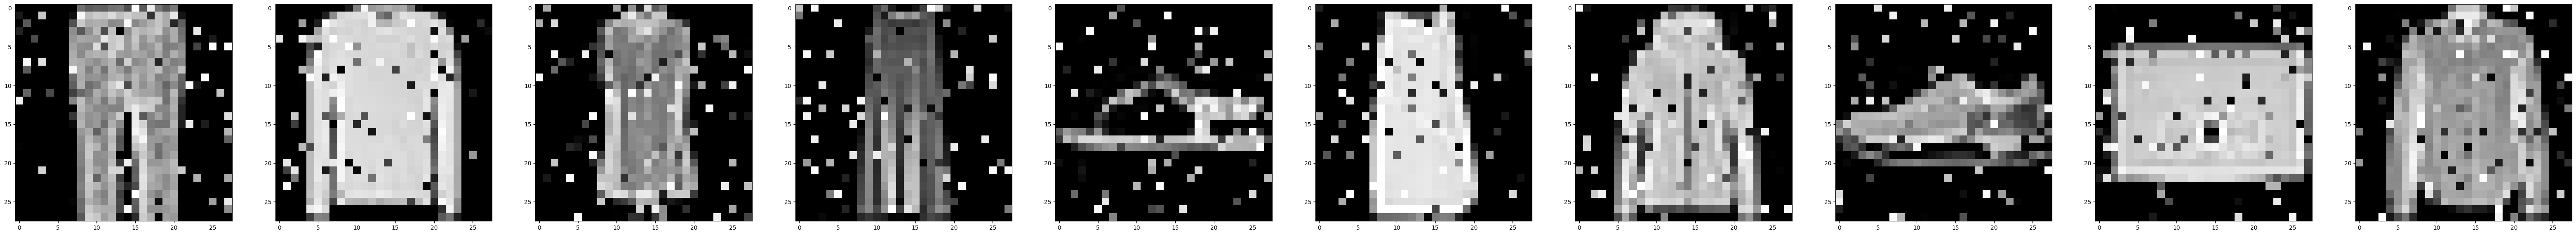

In [39]:
n = np.random.randint(0,len(val_x)-5)
f, ax = plt.subplots(1,10)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+10)):
    ax[i].imshow(val_x_n[a, :, :, 0].reshape(28, 28))
plt.show()

In [40]:
preds = model_2.predict(val_x_n[n:n+5])
preds.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


(5, 4, 4, 32)

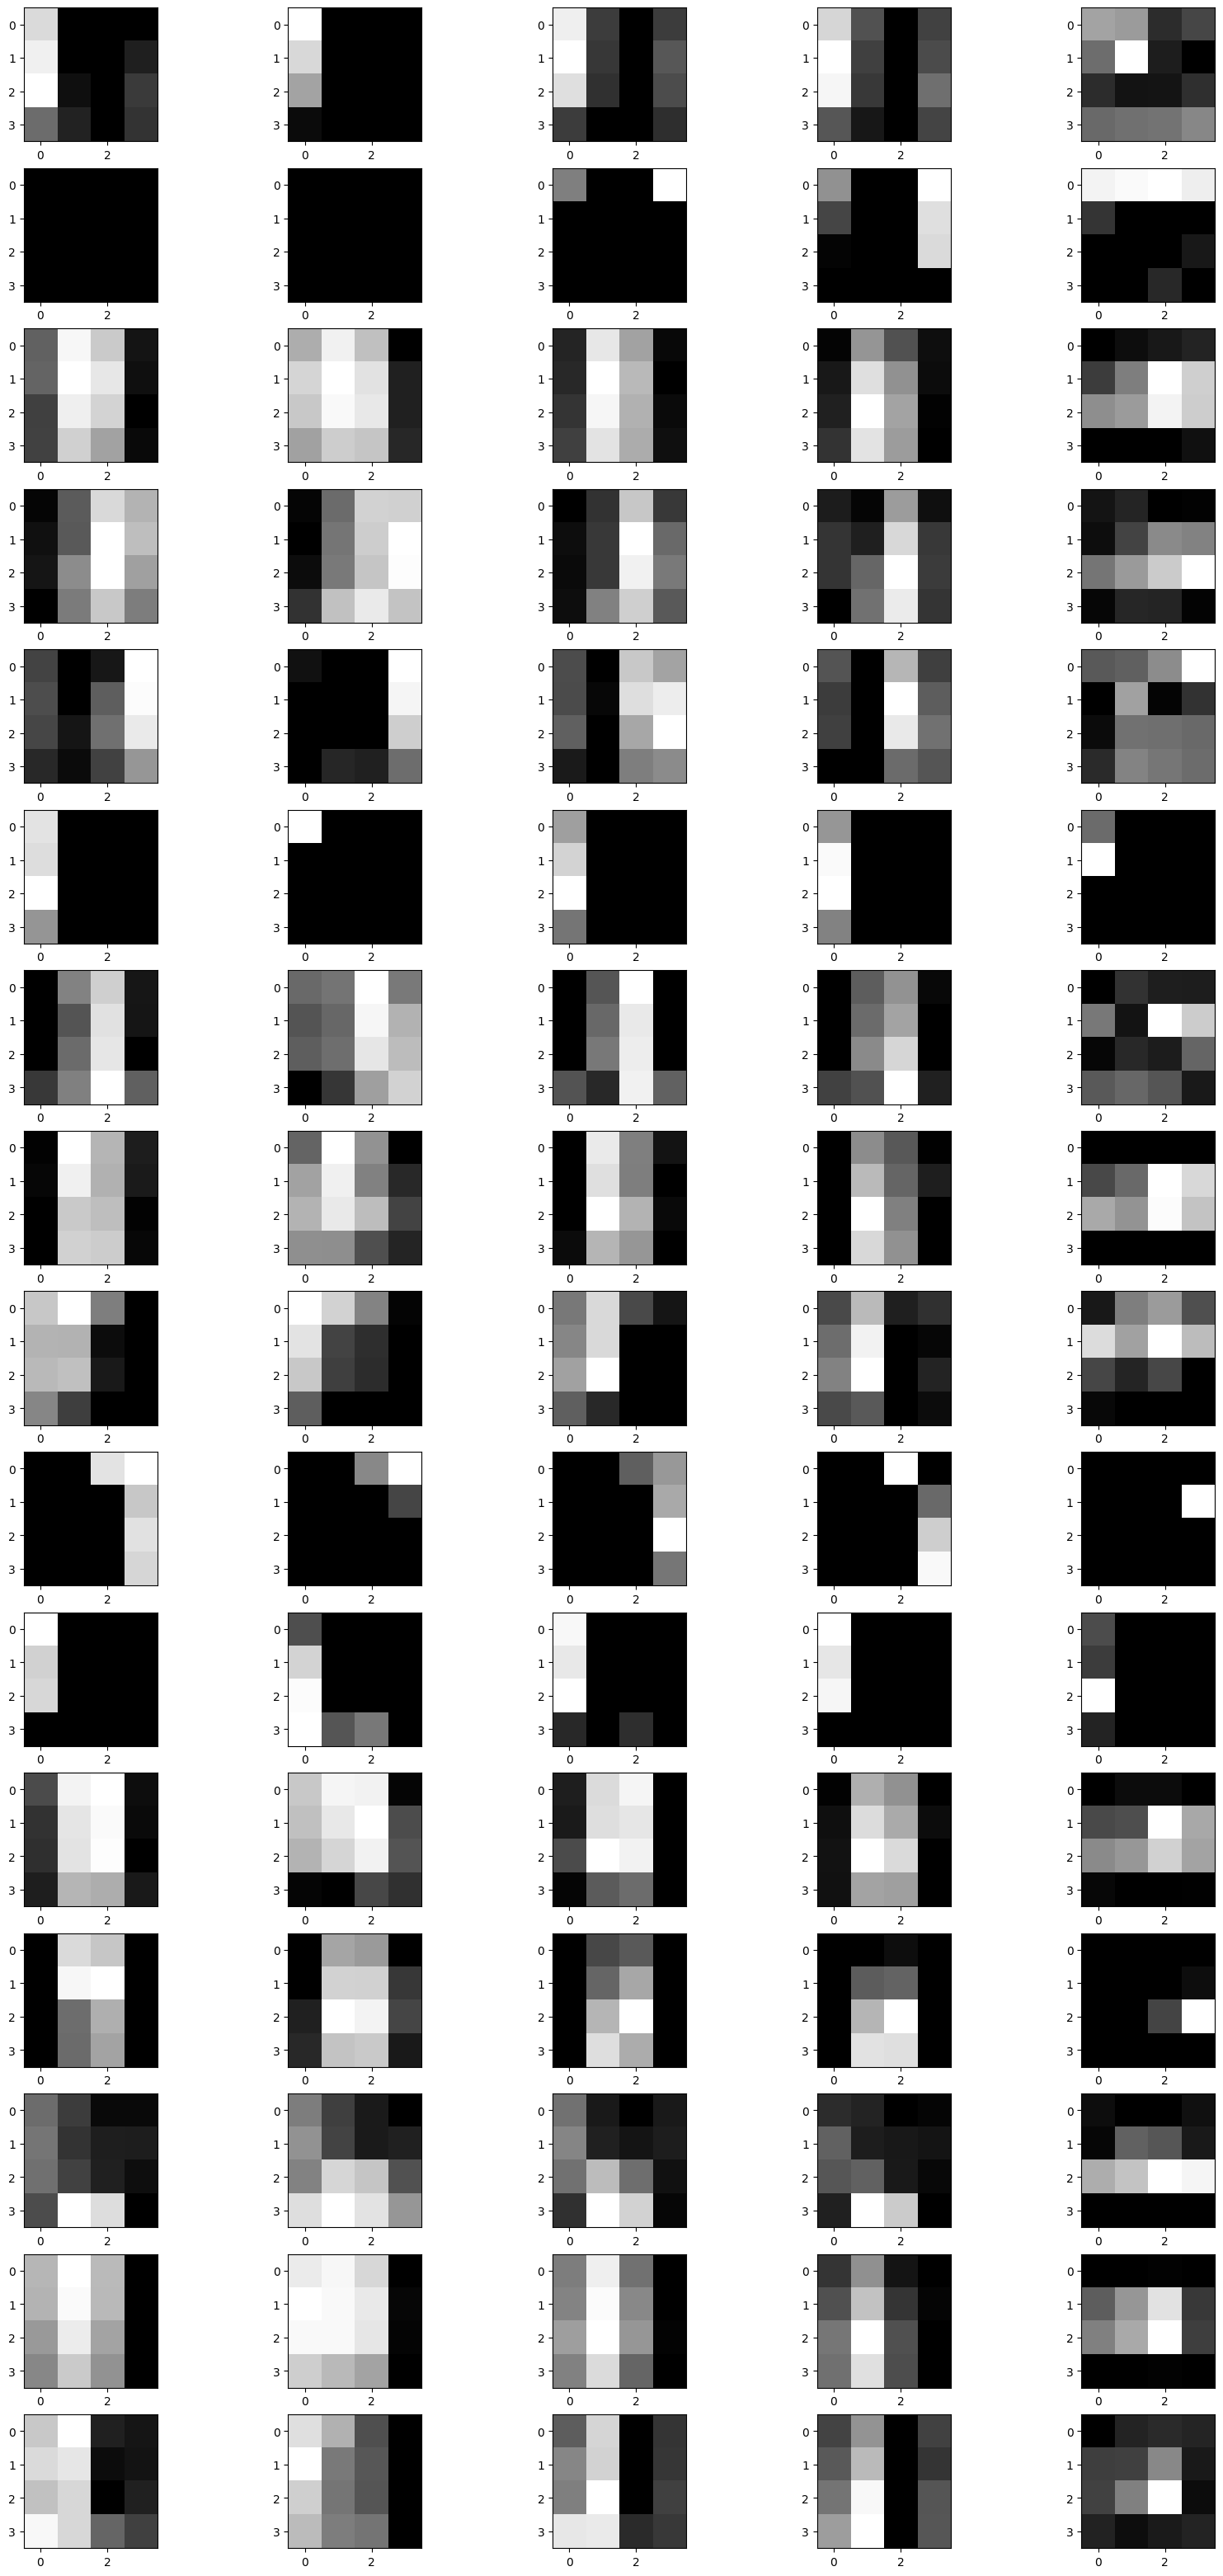

In [44]:
f, ax = plt.subplots(16,5)
ax = ax.ravel()
f.set_size_inches(20, 40)
for j in range(16):
    for i,a in enumerate(range(n,n+5)):
        ax[j*5 + i].imshow(preds[i, :, :, j])
plt.show()

### Visualize Samples reconstructed by AE

In [45]:
n = np.random.randint(0,len(val_x)-5)

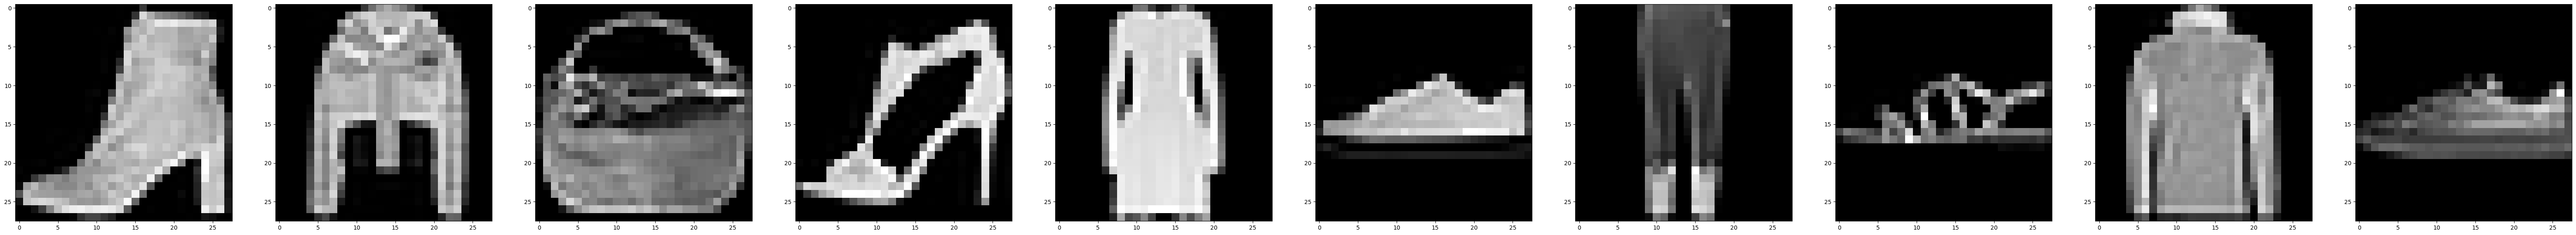

In [48]:
f, ax = plt.subplots(1,10)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+10)):
    ax[i].imshow(val_x[a, :, :, 0].reshape(28, 28))

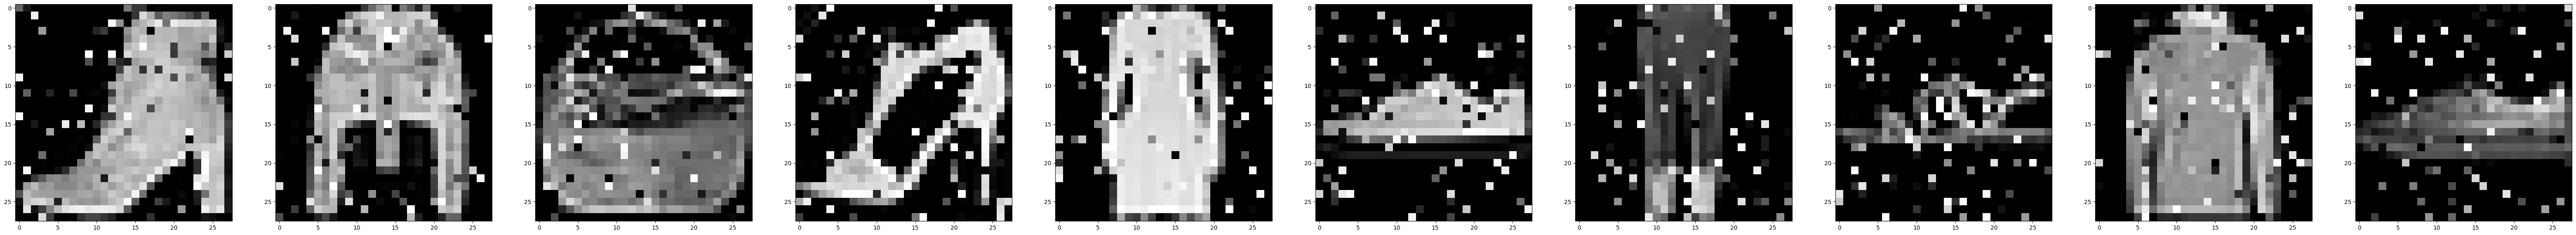

In [49]:
f, ax = plt.subplots(1,10)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+10)):
    ax[i].imshow(val_x_n[a, :, :, 0].reshape(28, 28))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step


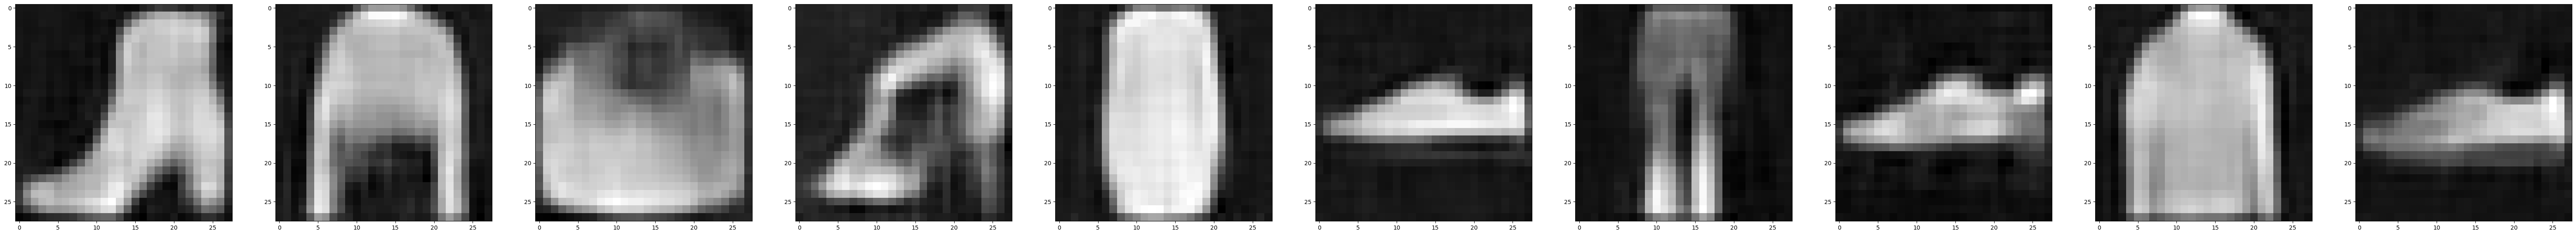

In [52]:
preds = model.predict(val_x_n[n:n+10])
f, ax = plt.subplots(1,10)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+10)):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

#### **Question-7: Compare the reconstructed outputs with the original inputs. What patterns or differences do you observe?**


Differences indicate areas where the model struggles to generalize or where important features are lost.

Overfitting may produce near-perfect reconstructions for training data but fail for unseen data. And also that the predictions are improper at the edges due to variations

#### **Question-8: How can the quality of reconstructions indicate overfitting or underfitting in the autoencoder model?**

**Overfitting**: Reconstructions of training data are nearly perfect, but performance on unseen data is poor.

**Underfitting:** Reconstructions are poor for both training and unseen data, indicating the model lacks capacity to represent the data.


#### **Question-9: Why are autoencoders well-suited for tasks like denoising or dimensionality reduction?**


The latent space filters out noise and retains essential features, making autoencoders effective for denoising and reducing the dimensionality of input data.



#### **Question-10: How might the learned representations (latent space) of the autoencoder be used in downstream tasks such as classification or clustering?**

The latent space captures essential features, which can be fed into classifiers or clustering algorithms to improve performance by focusing on meaningful data representations.

## Part 3: Exercise: Denoising noisy documents

Download the data given at the following link:

https://drive.google.com/file/d/12BHoFGqhwQlO2tks-QyTFSh0Q0Ceg_XL/view?usp=sharing

In [54]:
!unzip '/content/Lab 13-noisy_docs_data_.zip'

Archive:  /content/Lab 13-noisy_docs_data_.zip
   creating: test/
  inflating: test/88.png             
   creating: __MACOSX/test/
  inflating: __MACOSX/test/._88.png  
  inflating: test/214.png            
  inflating: __MACOSX/test/._214.png  
  inflating: test/76.png             
  inflating: __MACOSX/test/._76.png  
  inflating: test/163.png            
  inflating: __MACOSX/test/._163.png  
  inflating: test/175.png            
  inflating: __MACOSX/test/._175.png  
  inflating: test/202.png            
  inflating: __MACOSX/test/._202.png  
  inflating: test/49.png             
  inflating: __MACOSX/test/._49.png  
  inflating: test/61.png             
  inflating: __MACOSX/test/._61.png  
  inflating: test/160.png            
  inflating: __MACOSX/test/._160.png  
  inflating: test/148.png            
  inflating: __MACOSX/test/._148.png  
  inflating: test/70.png             
  inflating: __MACOSX/test/._70.png  
  inflating: test/64.png             
  inflating: __MACOSX/test

In [55]:
TRAIN_IMAGES = glob.glob('/content/train/*.png')
CLEAN_IMAGES = glob.glob('/content/train_cleaned/*.png')
TEST_IMAGES = glob.glob('/content/test/*.png')

(420, 540)


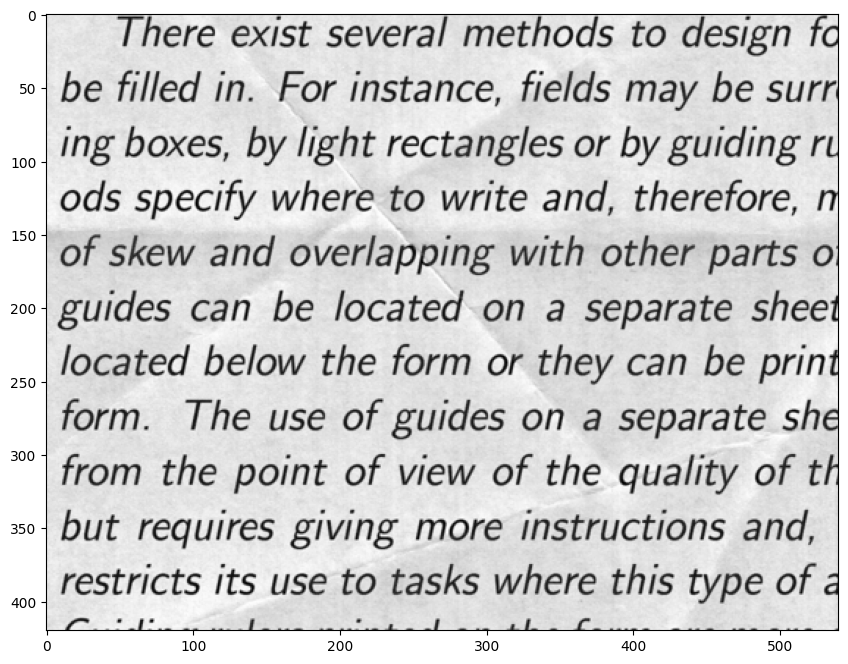

In [57]:
plt.figure(figsize=(20,8))
img = cv2.imread('/content/train/101.png', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

In [60]:
def load_image(path):
    image_list = np.zeros((len(path), 258, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(258, 540))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x

    return image_list

x_train = load_image(TRAIN_IMAGES)
y_train = load_image(CLEAN_IMAGES)
x_test = load_image(TEST_IMAGES)

print(x_train.shape, x_test.shape)

(144, 258, 540, 1) (72, 258, 540, 1)


In [61]:
#Todo: Split your dataset into train and val
x_train, x_val = train_test_split(x_train, test_size=0.2)
y_train, y_val = train_test_split(y_train, test_size=0.2)

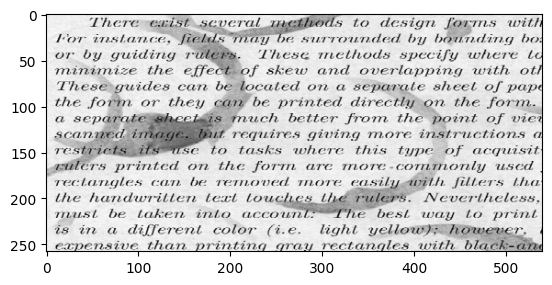

In [69]:
#Todo: Visualize your train set
plt.imshow(x_train[0, :, :, 0])

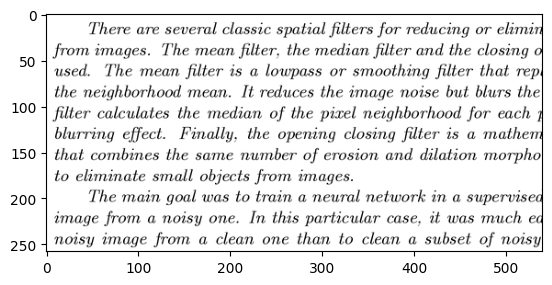

In [70]:
plt.imshow(y_train[0, :, :, 0])

In [73]:
input_layer = Input(shape=(258, 540, 1))

#Todo: Setup encoder
#Hint: Conv2D - > MaxPooling

encoded_layer1 = Conv2D(128, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)

#Todo: Setup decoder
#Hint: Conv2D - > Upsampling

decoded_layer1 = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded_layer1)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)

output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded_layer1)

ae = Model(input_layer, output_layer)

In [74]:
#Todo: Compile and summarize your auto encoder
ae.compile(optimizer='adam', loss='mse')
ae.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 258, 540, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 258, 540, 128)       │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 129, 270, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 129, 270, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_8 (UpSampling2D)       │ (None, 258, 540, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 258, 540, 1)         │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 150,017 (586.00 KB)

 Trainable params: 150,017 (586.00 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
#Todo: Train your autoencoder
ae.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 62s 13s/step - loss: 0.0710 - val_loss: 0.0741
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 437ms/step - loss: 0.0714 - val_loss: 0.0741
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - loss: 0.0712 - val_loss: 0.0741
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - loss: 0.0714 - val_loss: 0.0741
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 447ms/step - loss: 0.0717 - val_loss: 0.0740
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - loss: 0.0713 - val_loss: 0.0740
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - loss: 0.0712 - val_loss: 0.0739
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - loss: 0.0699 - val_loss: 0.0739
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step - loss: 0.0704 - val_loss: 0.0738
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - loss: 0.0719 - val_loss: 0.0738
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - loss: 0.0705 - val_loss: 0.0736
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - loss: 0.0711 - val_lo

In [81]:
preds = ae.predict(x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


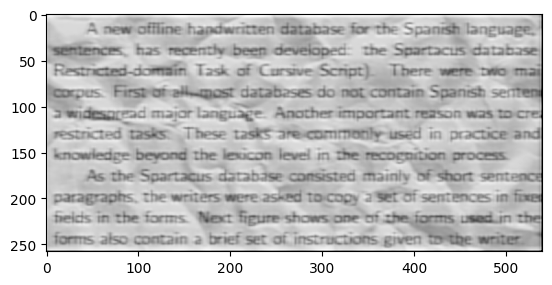

In [82]:
#Todo: Visualize samples reconstructed by AE
plt.imshow(preds[0, :, :, 0])

## Part 4: Generating New Fashion using VAEs

### Understanding VAEs

Reference Article:

https://www.linkedin.com/pulse/understanding-variational-autoencoders-vaes-how-useful-raja

https://medium.com/geekculture/variational-autoencoder-vae-9b8ce5475f68

!["VAE"](https://media.licdn.com/dms/image/v2/D5612AQGKhOhkMg9-Eg/article-cover_image-shrink_600_2000/article-cover_image-shrink_600_2000/0/1686402991780?e=2147483647&v=beta&t=IHpw2ehP-2gHO4G5MAoHaBkkCC_0R8pw0OQfXT6Rz5A)

#### **Question-1: What is the primary difference between an autoencoder and a variational autoencoder?**


VAEs introduce a probabilistic framework where the latent representation is modeled as a distribution (e.g., Gaussian) rather than a fixed vector.

#### **Question-2: Why do VAEs use a probabilistic approach to encode data instead of deterministic encoding?**


This approach encourages the model to generalize better by learning distributions, enabling robust sampling and avoiding overfitting. Also as taught in lectures, the represtation and continuity helps make backprop possible and similar decoding of similar points in latent space.

#### **Question-3: What are the benefits of introducing a prior distribution (e.g., Gaussian) in the latent space?**

It ensures that the latent space is smooth and continuous, making it easier to sample meaningful representations for generating new data.

### Reset data

In [85]:
### read dataset
train = pd.read_csv("/content/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.2)

## create train and validation datasets
train_x, val_x = train_test_split(train_x, test_size=0.2)

In [86]:
## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

### Setup Encoder Neural Network

TASK: Try different number of hidden layers, nodes, etc.

In [87]:
import keras.backend as K

In [118]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

input_img = Input(shape=(784,), name="input")
x = Dense(512, activation='relu', name="intermediate_encoder")(input_img)
x = Dense(2, activation='relu', name="latent_encoder")(x)

z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

In [119]:
import tensorflow as tf

# Sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mu)[0], latent_dim), mean=0.0, stddev=1.0)
    return z_mu + tf.exp(z_log_sigma) * epsilon

# Sample vector from the latent distribution
z = Lambda(sampling, output_shape=(latent_dim,))([z_mu, z_log_sigma])

In [120]:
# decoder takes the latent distribution sample as input
decoder_input = Input((2,), name="input_decoder")

x = Dense(512, activation='relu', name="intermediate_decoder", input_shape=(2,))(decoder_input)

# Expand to 784 total pixels
x = Dense(784, activation='sigmoid', name="original_decoder")(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [121]:
decoder.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_decoder (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ intermediate_decoder (Dense)         │ (None, 512)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ original_decoder (Dense)             │ (None, 784)                 │         402,192 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 403,728 (1.54 MB)

 Trainable params: 403,728 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [122]:
class CustomVariationalLayer(Layer):
    def vae_loss(self, x, z_decoded):
        # Flatten the inputs and outputs
        x = tf.reshape(x, [-1])
        z_decoded = tf.reshape(z_decoded, [-1])
        # Reconstruction loss
        xent_loss = binary_crossentropy(x, z_decoded)
        return tf.reduce_mean(xent_loss)

    # Add the custom loss to the layer
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss)  # Removed `inputs` argument
        return x  # Output the original input for compatibility

    def compute_output_shape(self, input_shape):
        # The output shape matches the shape of the input image
        return input_shape[0]

# Apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [123]:
z_decoded

<KerasTensor shape=(None, 784), dtype=float32, sparse=False, name=keras_tensor_70>

In [124]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [125]:
vae.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 784)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ intermediate_encoder      │ (None, 512)            │        401,920 │ input[0][0]            │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_encoder (Dense)    │ (None, 2)              │          1,026 │ intermediate_encoder[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │              6 │ latent_encoder[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 2)              │              6 │ latent_encoder[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 2)              │              0 │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_8 (Functional) │ (None, 784)            │        403,728 │ lambda_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_variational_layer… │ (None, 784)            │              0 │ input[0][0],           │
│ (CustomVariationalLayer)  │                        │                │ functional_8[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 806,686 (3.08 MB)

 Trainable params: 806,686 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In [126]:
train_x.shape

(38400, 784)

In [127]:
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

In [128]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

Epoch 1/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.4568 - val_loss: 0.3680
Epoch 2/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.3571 - val_loss: 0.3509
Epoch 3/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3485 - val_loss: 0.3467
Epoch 4/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.3450 - val_loss: 0.3416
Epoch 5/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3399 - val_loss: 0.3409
Epoch 6/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.3372 - val_loss: 0.3397
Epoch 7/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3365 - val_loss: 0.3365
Epoch 8/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.3353 - val_loss: 0.3354
Epoch 9/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3357 - val_loss: 0.3359
Epoch 10/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3334 - val_loss: 0.3340
Epoch 11/20
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3329 - val_loss: 0.3342
Epoch 12/20
2400/2400 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

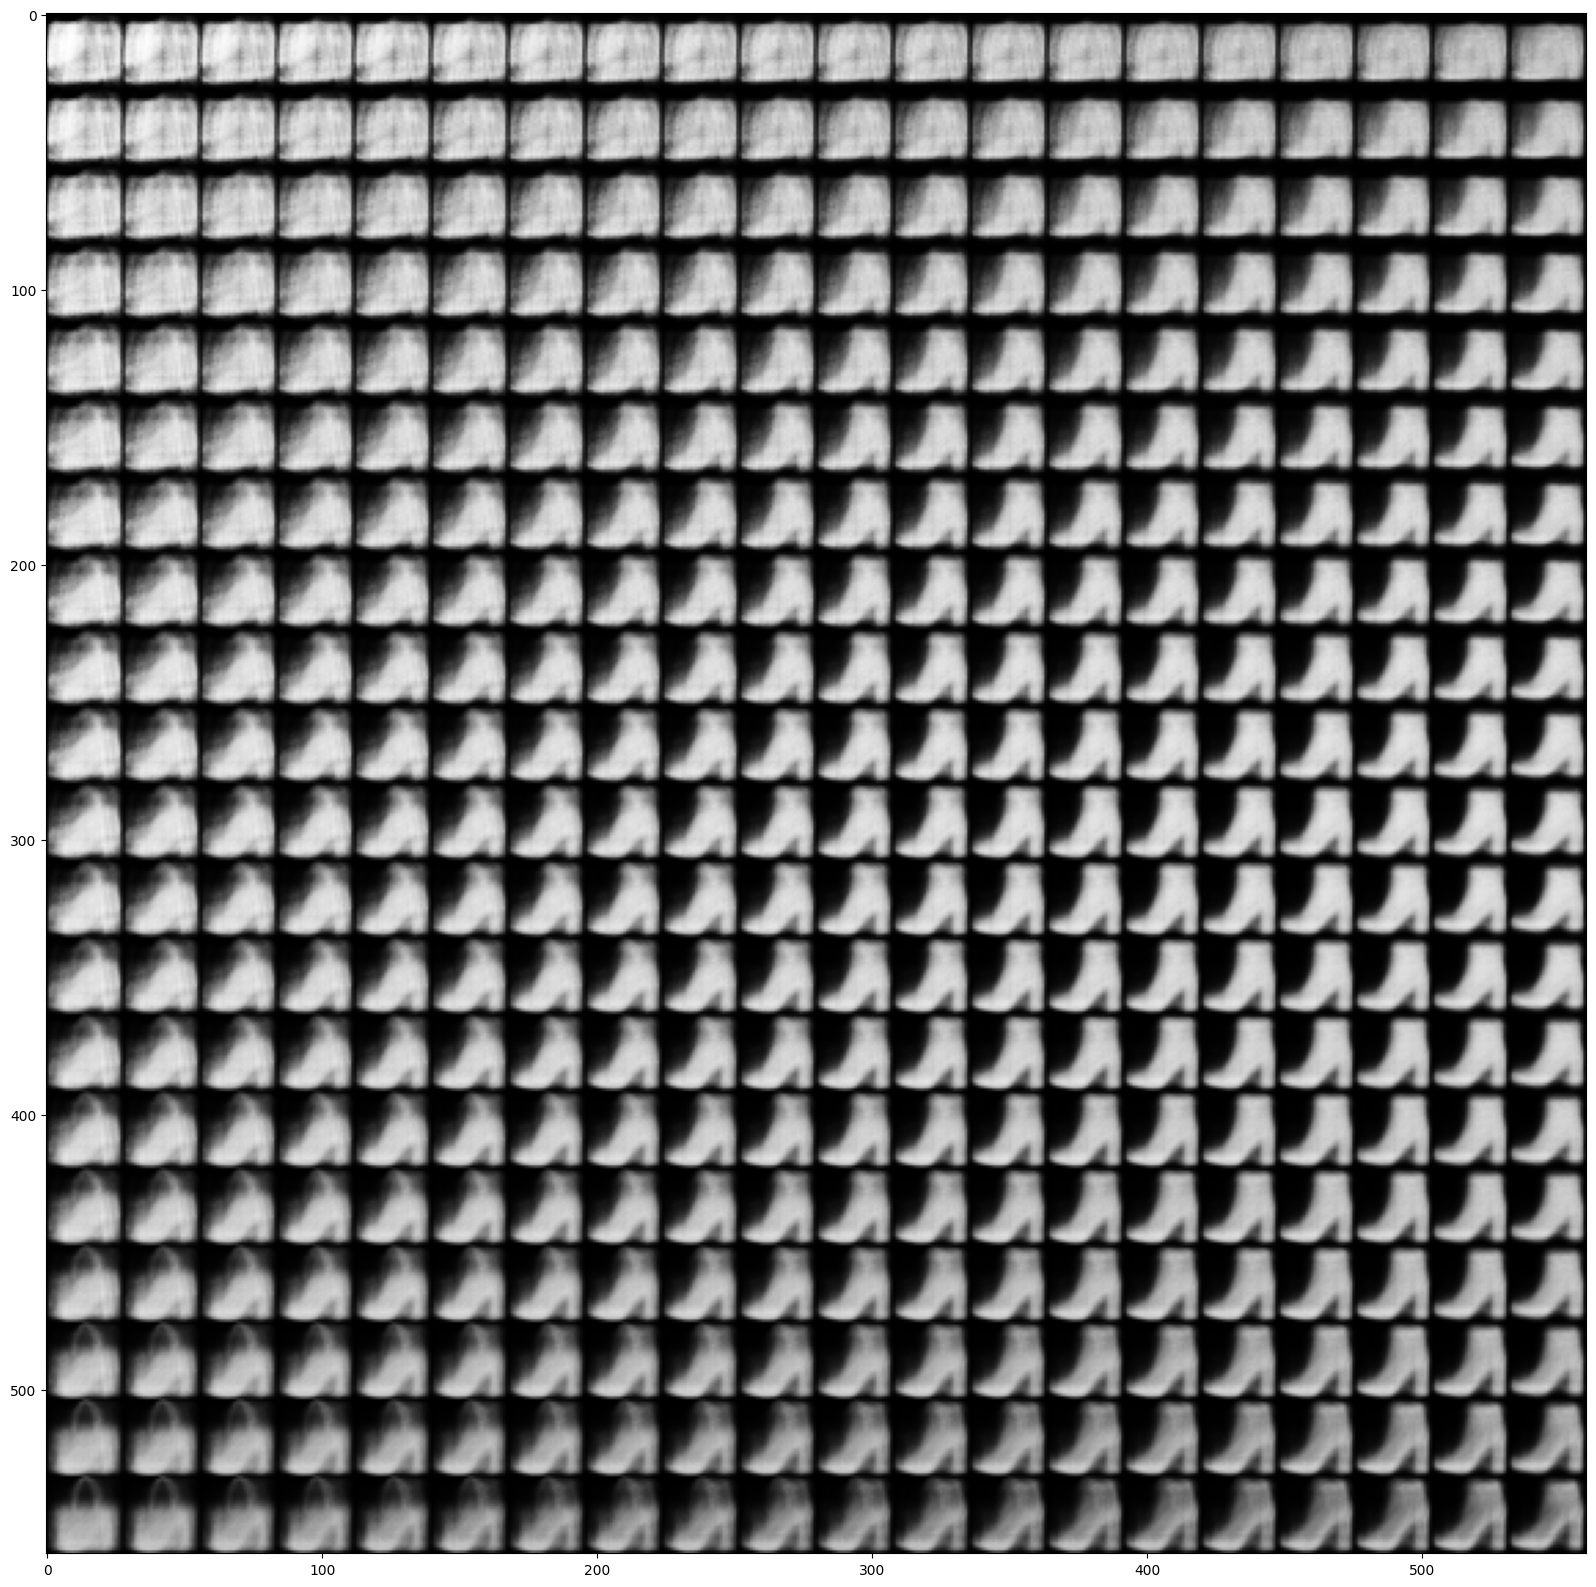

In [129]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)

        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


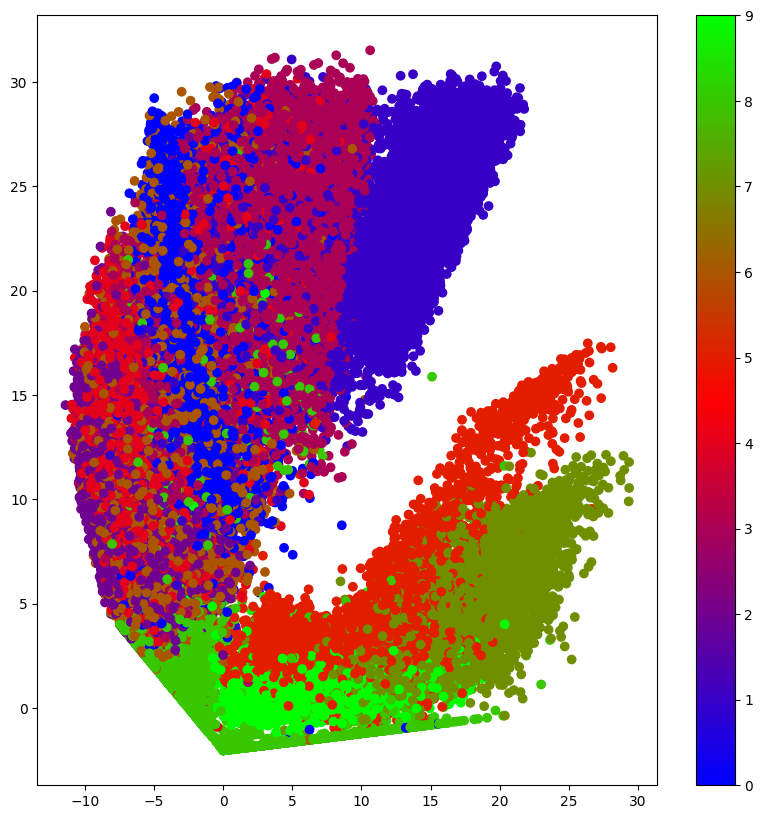

In [130]:
### read dataset
train = pd.read_csv("fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train[list(train.columns)[0]].values

train_x = train_x/255.
# train_x = train_x.reshape(-1, 28, 28, 1)

# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=train_y, cmap='brg')
plt.colorbar()
plt.show()

## Part 5: Exercise: Generating New Fashion using VAEs: Adding CNNs and KL Divergence Loss

In [135]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Hint: Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = Input(shape=(28, 28, 1))


#Todo: Setup encoder network
x = Conv2D(64, 3,
                  padding='same',
                  activation='relu')(input_img)
x = Conv2D(128, 3,
                  padding='same',
                  activation='relu',
                  strides=(2, 2))(x)
x = Conv2D(128, 3,
                  padding='same',
                  activation='relu')(x)
x = Conv2D(128, 3,
                  padding='same',
                  activation='relu')(x)


shape_before_flattening = tf.keras.backend.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

### Set up sampling function

In [137]:
# Sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mu)[0], latent_dim), mean=0.0, stddev=1.0)
    return z_mu + tf.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

#### **Question-4: How does sampling from the latent space in VAEs differ from deterministic encoding in standard autoencoders?**

Instead of fixed points, VAEs sample from the learned latent distributions, allowing for variability and robustness in data generation.

### Setup Decoder Neural Network

Try different number of hidden layers, nodes?

**Changed layer sizes**

In [139]:
# decoder takes the latent distribution sample as input
decoder_input = Input(tf.keras.backend.int_shape(z)[1:])

#Todo: Setup decoder network
#Hint Expand to 784 pixels -> reshape -> Conv2Dtranspose -> conv2D
# Expand to 784 total pixels
x = Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)
x = Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

### Set up loss functions

In [141]:
# construct a custom layer to calculate the loss

def vae_loss(self, x, z_decoded, z_mu, z_log_sigma):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    # Reconstruction loss
    xent_loss = binary_crossentropy(x, z_decoded)
    # KL divergence
    kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
    return K.mean(xent_loss + kl_loss)

# adds the custom loss to the class
def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    z_mu = inputs[2]  # Mean of the encoded latent space
    z_log_sigma = inputs[3]  # Log variance of the encoded latent space
    loss = self.vae_loss(x, z_decoded, z_mu, z_log_sigma)
    self.add_loss(loss, inputs=inputs)
    return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded, z_mu, z_log_sigma])

#### **Question-5: What are the two components of the VAE loss function, and what does each represent?**


**Reconstruction Loss:** Measures how well the output matches the input.

**KL Divergence:** Ensures that the learned latent distribution aligns with the prior distribution.

#### **Question-6: How does the KL divergence term help regulate the latent space in a VAE?**

It penalizes deviations from the prior distribution, encouraging a structured and meaningful latent space.

### Train VAE

In [142]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [143]:
vae.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 28, 28, 64)     │            640 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 14, 14, 128)    │         73,856 │ conv2d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 14, 14, 128)    │        147,584 │ conv2d_36[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 14, 14, 128)    │        147,584 │ conv2d_37[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │        802,848 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 2)              │             66 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 2)              │             66 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_7 (Lambda)         │ (None, 2)              │              0 │ dense_5[0][0],         │
│                           │                        │                │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_11             │ (None, 28, 28, 1)      │        112,449 │ lambda_7[0][0]         │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_variational_layer… │ (None, 28, 28, 1)      │              0 │ input_layer_9[0][0],   │
│ (CustomVariationalLayer)  │                        │                │ functional_11[0][0],   │
│                           │                        │                │ dense_5[0][0],         │
│                           │                        │                │ dense_6[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,285,093 (4.90 MB)

 Trainable params: 1,285,093 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

In [144]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [145]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

Epoch 1/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.3947 - val_loss: 0.3382
Epoch 2/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.3348 - val_loss: 0.3321
Epoch 3/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.3302 - val_loss: 0.3378
Epoch 4/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.3282 - val_loss: 0.3268
Epoch 5/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.3259 - val_loss: 0.3263
Epoch 6/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.3252 - val_loss: 0.3246
Epoch 7/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.3244 - val_loss: 0.3236
Epoch 8/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.3231 - val_loss: 0.3230
Epoch 9/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.3235 - val_loss: 0.3235
Epoch 10/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.3222 - val_loss: 0.3225
Epoch 11/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.3218 - val_loss: 0.3219
Epoch 12/20
3750/37

### Visualize Samples reconstructed by VAE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━

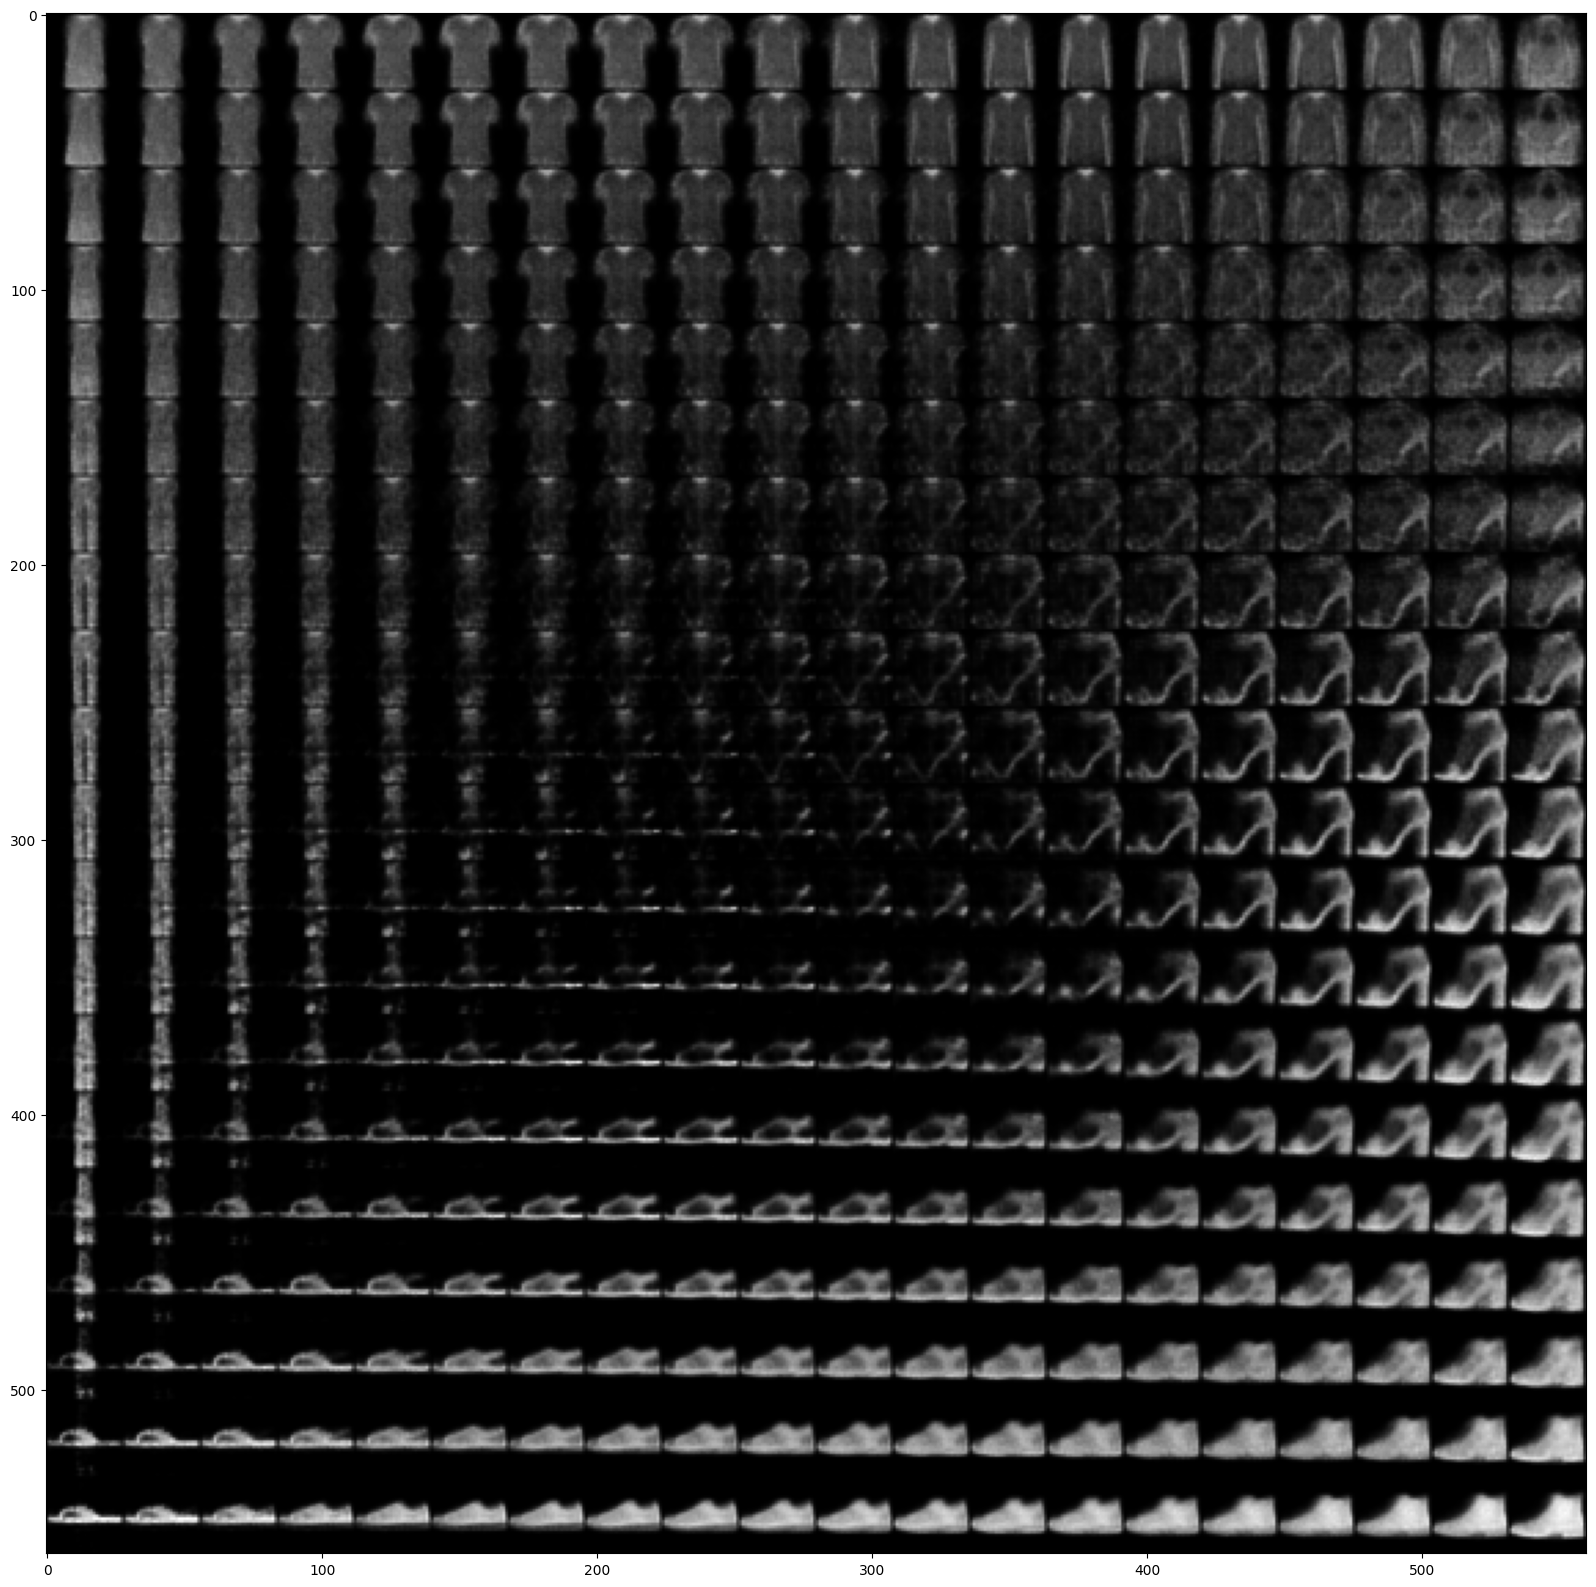

In [146]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()

#### **Question-7: What do you observe about the generated samples? How does the latent space structure affect these samples?**


Generated samples reflect the quality and smoothness of the latent space. A well-structured latent space produces realistic and diverse samples.

#### **Question-8: What are some practical applications of VAEs in areas like image generation, anomaly detection, or recommendation systems?**

**Image Generation:** Creating new images by sampling from the latent space.

**Anomaly Detection:** Identifying deviations from the learned data distribution.

**Recommendation Systems:** Generating personalized suggestions based on latent representations.

## Exercise: Visualize latent space

In [147]:
train = pd.read_csv("/content/fashion-mnist_train.csv")

In [149]:
### read dataset
train = pd.read_csv("/content/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train[list(train.columns)[0]].values

train_x = train_x/255.
train_x = train_x.reshape(-1, 28, 28, 1)

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


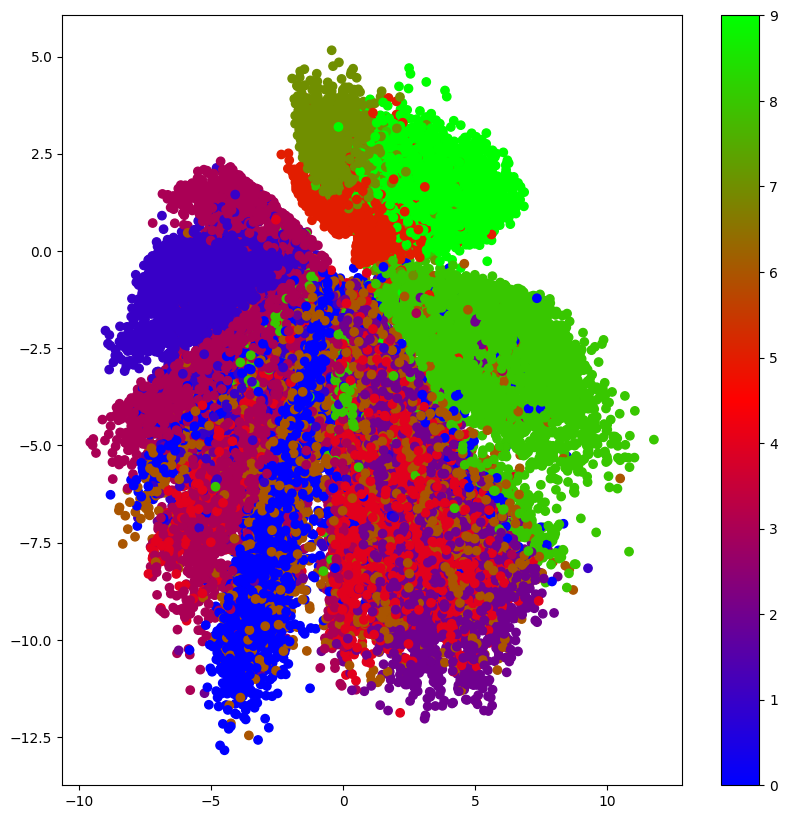

In [150]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=train_y, cmap='brg')
plt.colorbar()
plt.show()

#### **Question-9: Why is it important to experiment with different architectures and hyperparameters for autoencoders and VAEs?**


Optimal architectures and hyperparameters improve reconstruction quality, convergence speed, and robustness across tasks.

#### **Question-10: What challenges might arise when training autoencoders or VAEs on high-dimensional datasets, and how could these be mitigated?**


**Challenges:** Overfitting, slow convergence, and memory constraints.

**Mitigation:** Dimensionality reduction, regularization, and scalable architectures.

#### **Question-11: Compare the strengths and weaknesses of autoencoders and variational autoencoders. When would you use one over the other?**

**Autoencoders:** Simple, effective for tasks like denoising and dimensionality reduction.

**VAEs:** Better for generative tasks due to probabilistic encoding.
Use VAEs when the task involves generating new samples or learning meaningful latent space structures.


## Submission Guidlines

# **Autoencoders (AE)**

An autoencoder is a type of neural network that tries to learn how to compress data (like images or text) and then reconstruct it back. It has two main parts:


**Encoder:** Takes the input and squeezes it into a smaller, simpler form (called the latent space).

**Decoder:** Tries to recreate the original input from that compressed form.

The goal is to minimize the difference between the original input and the reconstructed output. This is great for things like:

**Compression:** Reducing data size

**Denoising:** Removing noise from images

**Feature extraction:** Learning important features of the data

The loss function usually used to measure how well the model is doing is Mean Squared Error (MSE), which looks at how much the reconstruction differs from the input.




# **Variational Autoencoders (VAE)**

VAEs are an upgraded version of autoencoders with a twist: instead of learning a single compressed representation, the encoder learns a probability distribution for the latent space. This means that instead of getting just one point, we get a whole range of possible points (like a distribution of possible "compressions").


**Encoder:** Outputs parameters (mean and variance) for a distribution that represents the latent space, rather than a fixed point.

**Decoder:** Uses the sampled values from that distribution to recreate the original input.

The big difference here is that VAEs don’t just try to reconstruct the data—they also regularize the latent space to make sure it follows a known distribution (like a normal distribution). This helps in generating new data from the latent space.

The loss function for VAEs is a combination of:

**Reconstruction Loss:** Like in autoencoders, it's the difference between the original and the reconstructed data.
KL Divergence: A term that ensures the learned latent space distribution stays close to a known distribution (usually Gaussian), which makes VAEs useful for generating new data.



# Key Takeaways:

Autoencoders compress and reconstruct data, and are mainly used for tasks like noise removal and dimensionality reduction.

VAEs go a step further by modeling the latent space probabilistically, allowing them to generate new data by sampling from the latent space.

In the lab, I learned that the main difference between these two is how they handle the latent space—autoencoders just compress it into a point, while VAEs treat it as a distribution. This lets VAEs be used for generative tasks, like creating new images or data that look similar to the original data.

> **Submit the notebook with given questions answered and all the outputs visible.**

> **Write your understanding of the topics covered in the lab at the end of the notebook in your own words. Avoid using generative AI.**